# Synthetic classification tasks

In [13]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tqdm

from pytorchtools import EarlyStopping

import models as m
import torch_utils as tu
from torch_utils import DatasetSpec
import utils as u
import viz as v

In [2]:
tu.set_seed()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

Random seed set as 42


device(type='cuda')

### Load M. buryatense expression data with 300bp upstream regions

In [3]:
data_filename = "data/XY_lr_noCu_opFilt_20221031.tsv"
XYdf = pd.read_csv(data_filename,sep='\t')
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,0.047594,0.823884,-0.215152,-0.117634,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,0.175844,1.069860,-0.135315,-0.244793,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,0.087538,0.940938,-0.153989,-0.249011,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,0.032773,0.520115,-0.260747,0.643283,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,0.064979,-0.141051,0.073257,0.539188,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,0.008150,-0.382673,1.440100,0.977712,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,-0.005709,-0.374488,1.421917,0.952955,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,0.015365,-0.322437,1.406791,0.899683,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,-0.183282,0.157790,-0.270536,-0.233161,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502


# 2. Synthetic 6-mer motif classification in 300bp seqs

In [4]:
score_dict = {
    'A':5,
    'C':2,
    'G':-2,
    'T':-5,
    'N':0
}

def score_seq(seq):
    score = np.mean([score_dict[base] for base in seq])
    if 'TATATA' in seq:
        score += 10
    if 'GCGCGC' in seq:
        score -= 10
    return score

XYdf['score'] = XYdf['upstream_region'].apply(lambda x: score_seq(x))
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,score
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,...,0.823884,-0.215152,-0.117634,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153,-0.563333
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,...,1.069860,-0.135315,-0.244793,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073,-0.130000
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,...,0.940938,-0.153989,-0.249011,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513,-0.073333
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,...,0.520115,-0.260747,0.643283,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145,0.220000
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,...,-0.141051,0.073257,0.539188,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915,-0.146667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,...,-0.382673,1.440100,0.977712,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701,0.383333
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,...,-0.374488,1.421917,0.952955,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205,0.383333
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,...,-0.322437,1.406791,0.899683,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817,-0.220000
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,...,0.157790,-0.270536,-0.233161,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502,-0.236667


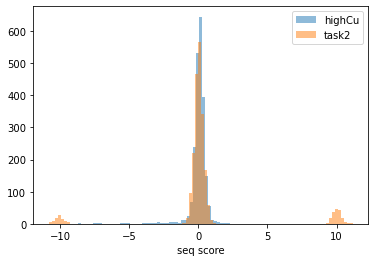

In [5]:
plt.hist(XYdf['highCu'],bins=50,alpha=0.5,label='highCu')
plt.hist(XYdf['score'],bins=100,alpha=0.5,label='task2')
plt.xlabel("seq score")
plt.legend()
plt.show()

In [6]:
tu.set_reg_class_up_down(XYdf,'score',thresh=5)
XYdf['score_reg_UD'].value_counts()

1    1954
2     169
0      88
Name: score_reg_UD, dtype: int64

In [7]:
# rename for convenience
XYdf = XYdf.rename(columns={'score_reg_UD':'task2_class'})
XYdf.columns

Index(['og_index', 'locus_tag', 'upstream_region', 'uMax', 'lowO2_fast_growth',
       'lowCH4', 'MeOH', 'NoCu', 'medCu', 'highCu', 'lowCu',
       'highO2_slow_growth', 'NO3_lowO2_slow_growth', 'WithLanthanum',
       'NoLanthanum', 'LanzaTech', 'aa3_KO', 'crotonic_acid', 'CH4_500ppm',
       'CH4_1000ppm', 'score', 'task2_class'],
      dtype='object')

### Train/test splitting
Use StratifiedShuffleSplit to make sure the percent of clases is preserved between train/test splits

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit 

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

Train counts:
1    1563
2     135
0      70
Name: task2_class, dtype: int64
Test counts:
1    391
2     34
0     18
Name: task2_class, dtype: int64


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


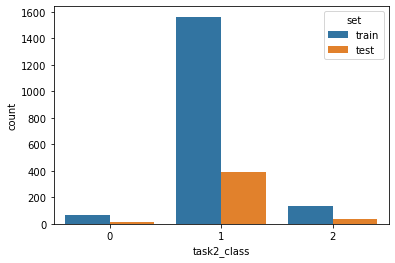

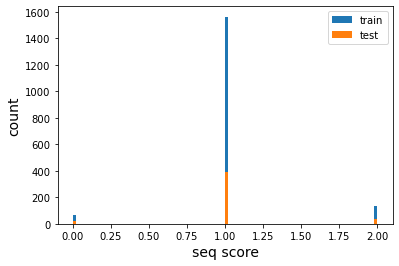

/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


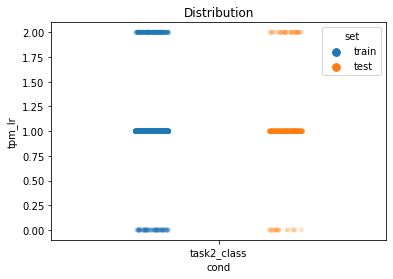

In [9]:
target_col = 'task2_class'
for i, (train_idxs, test_idxs) in enumerate(sss.split(XYdf, XYdf[target_col])):
    train_df = XYdf.iloc[train_idxs]
    test_df = XYdf.iloc[test_idxs]
    
    print(f"Train counts:\n{train_df[target_col].value_counts()}")
    print(f"Test counts:\n{test_df[target_col].value_counts()}")
    
    v.plot_train_test_stacks(train_df, test_df, score_col=target_col)
    v.plot_train_test_hist(train_df, test_df,score_col=target_col,bins=100)
    v.view_train_test_dist(train_df, test_df,[target_col],id_col='locus_tag')


## Load seqs into data loaders

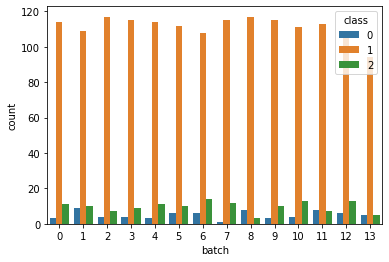

In [10]:
seq_col = 'upstream_region'
target_col = 'task2_class'

dataset_types = [
    DatasetSpec('ohe'),
]

dls = tu.build_dataloaders(
    train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=None
)


ohe_train_dl,ohe_val_dl = dls['ohe']

v.see_batch_class_dist(ohe_train_dl)

## Run models and collect stats

In [75]:
# class DNA_CNN_simple(nn.Module):
#     def __init__(self,
#                  seq_len,
#                  num_tasks,
#                  num_filters=31,
#                  fc_node_num1=100,
#                  fc_node_num2=10,
#                  kernel_size=3
#                 ):
#         super().__init__()
#         self.seq_len = seq_len
#         self.num_tasks = num_tasks
#         self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
#         self.conv_net = nn.Sequential(
#             nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
#             # ^^ changed from 4 to 1 channel??
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(self.lin_nodes, fc_node_num1),
#             nn.ReLU(),
#             nn.Linear(fc_node_num1, fc_node_num2),
#             nn.ReLU(),
#             nn.Linear(fc_node_num2,self.num_tasks),            
#         ) 

#     def forward(self, xb):
#         # reshape view to batch_ssize x 4channel x seq_len
#         # permute to put channel in correct order
#         xb = xb.permute(0,2,1).unsqueeze(1)
#         # ^^ Conv2D input fix??
#         out = self.conv_net(xb)
#         return out


In [11]:
model_res = {}
pred_dfs = {}
seq_len = len(train_df[seq_col].values[0])

E:104 | train loss:0.295 | val loss: 0.448:   3%|▎         | 104/3000 [00:10<04:11, 11.51it/s]

EarlyStopping counter: 50 out of 200


E:154 | train loss:0.198 | val loss: 0.490:   5%|▌         | 154/3000 [00:14<04:08, 11.45it/s]

EarlyStopping counter: 100 out of 200


E:204 | train loss:0.131 | val loss: 0.556:   7%|▋         | 204/3000 [00:19<04:02, 11.52it/s]

EarlyStopping counter: 150 out of 200


E:252 | train loss:0.092 | val loss: 0.642:   8%|▊         | 252/3000 [00:23<04:16, 10.73it/s]


EarlyStopping counter: 200 out of 200
Early stopping


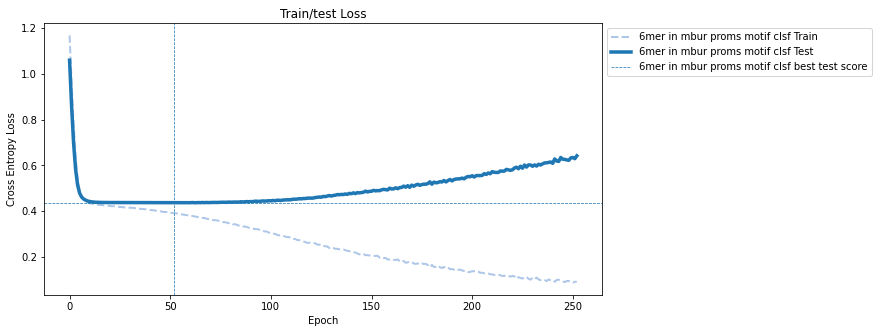

In [14]:
cnn1_name = "6mer in mbur proms motif clsf"
model = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=6,
    fc_node_num=10
)

model_res[cnn1_name] = tu.collect_model_stats(
    cnn1_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=3000,
    pat=200,
    opt=torch.optim.Adam,
    model=model,
    loss_type='classification'
)

Running predictions for 6mer in mbur proms motif clsf


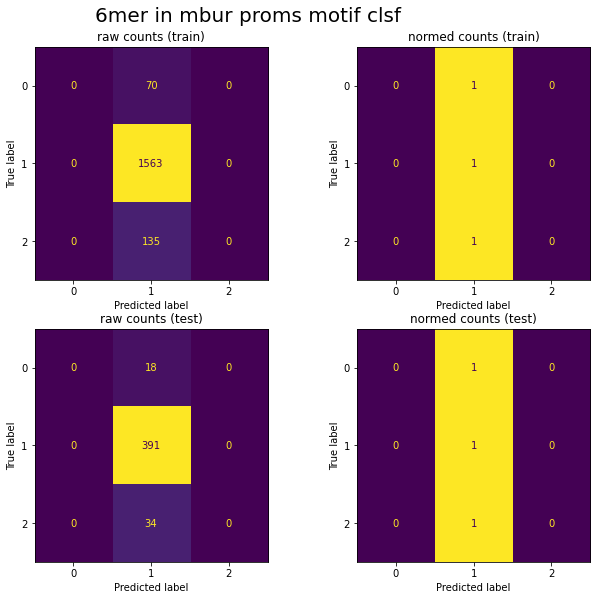

In [47]:
seq_col = 'upstream_region'
target_col = 'task2_class'

seq_list = [
    (train_df[seq_col].values,train_df[target_col],"train"),
    (test_df[seq_col].values,test_df[target_col],"test")
]

pred_dfs[cnn1_name] = tu.get_confusion_stats(
    model_res[cnn1_name]['model'],
    model_res[cnn1_name]['model_name'],
    seq_list,
    DEVICE,
    title=f"{model_res[cnn1_name]['model_name']}"
)

# Retry with a balanced sampler

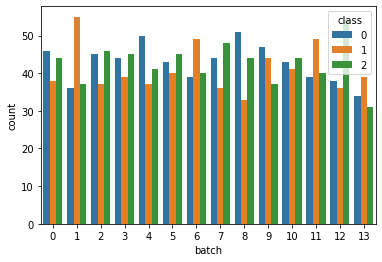

In [17]:
sampler = tu.make_weighted_sampler(train_df,target_col)
dls = tu.build_dataloaders(
    train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=sampler,
    shuffle=False
)

ohe_train_dl,ohe_val_dl = dls['ohe']

v.see_batch_class_dist(ohe_train_dl)

E:144 | train loss:0.124 | val loss: 0.667:   5%|▍         | 144/3000 [00:12<04:11, 11.35it/s]

EarlyStopping counter: 50 out of 200


E:194 | train loss:0.093 | val loss: 0.727:   6%|▋         | 194/3000 [00:17<04:08, 11.31it/s]

EarlyStopping counter: 100 out of 200


E:244 | train loss:0.072 | val loss: 0.781:   8%|▊         | 244/3000 [00:21<04:03, 11.32it/s]

EarlyStopping counter: 150 out of 200


E:292 | train loss:0.056 | val loss: 0.841:  10%|▉         | 292/3000 [00:26<04:01, 11.22it/s]


EarlyStopping counter: 200 out of 200
Early stopping


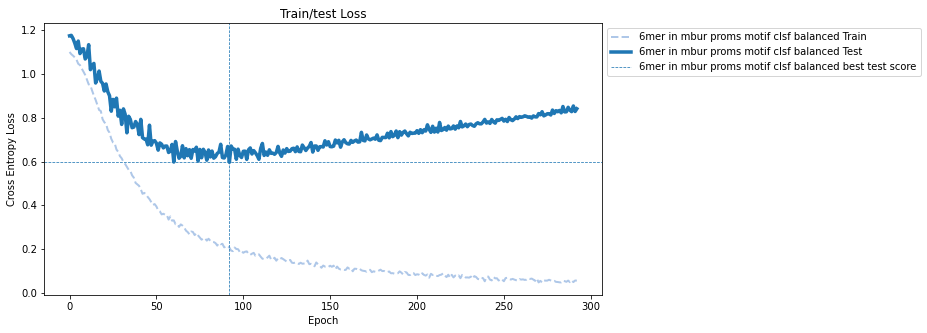

In [18]:
cnn2_name = "6mer in mbur proms motif clsf balanced"
model2 = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=6,
    fc_node_num=10
)

model_res[cnn2_name] = tu.collect_model_stats(
    cnn2_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=3000,
    pat=200,
    opt=torch.optim.Adam,
    model=model2,
    loss_type='classification'
)

Running predictions for 6mer in mbur proms motif clsf balanced


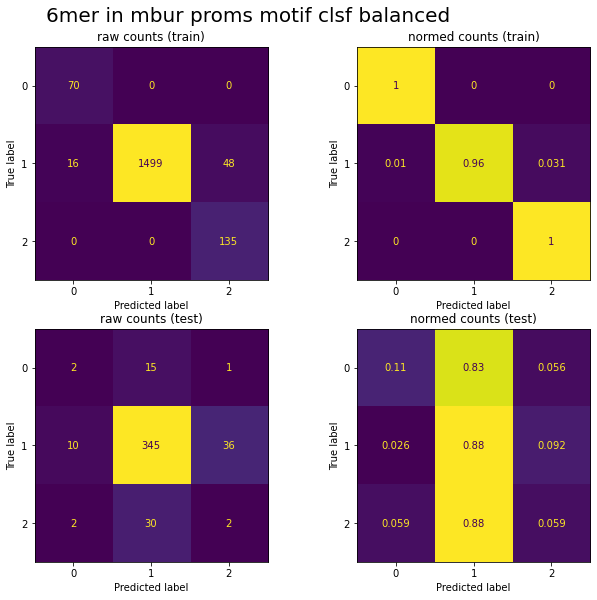

In [19]:
pred_dfs[cnn2_name] = tu.get_confusion_stats(
    model_res[cnn2_name]['model'],
    model_res[cnn2_name]['model_name'],
    seq_list,
    DEVICE,
    title=f"{model_res[cnn2_name]['model_name']}"
)

Hm, so far, not so good. Even rebalancing the sampler didn't prevent overfitting. Is it better than random though?

# Compare these results to shuffling the inputs sequences
Use the same class assignments for `posc` but shuffle the sequence so that the motif is usually lost

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


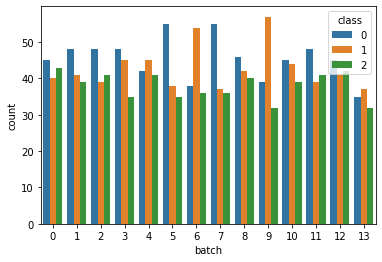

In [20]:
seq_col = 'shuffled_seq'
target_col = 'task2_class'

def shuffle_seq(dna):
    to_shuffle = list(dna)
    random.shuffle(to_shuffle)
    return  ''.join(to_shuffle)

train_df[seq_col] = train_df['upstream_region'].apply(lambda x: shuffle_seq(x))
test_df[seq_col] = test_df['upstream_region'].apply(lambda x: shuffle_seq(x))

dls_shuff = tu.build_dataloaders(
    train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=sampler,
    shuffle=False
)


ohe_train_dl_shuff,ohe_val_dl_shuff = dls_shuff['ohe']

v.see_batch_class_dist(ohe_train_dl_shuff)

E:148 | train loss:0.128 | val loss: 0.683:   5%|▍         | 149/3000 [00:13<04:10, 11.37it/s]

EarlyStopping counter: 50 out of 200


E:198 | train loss:0.089 | val loss: 0.749:   7%|▋         | 199/3000 [00:17<04:04, 11.48it/s]

EarlyStopping counter: 100 out of 200


E:248 | train loss:0.065 | val loss: 0.812:   8%|▊         | 249/3000 [00:21<04:00, 11.43it/s]

EarlyStopping counter: 150 out of 200


E:296 | train loss:0.050 | val loss: 0.873:  10%|▉         | 296/3000 [00:26<03:58, 11.35it/s]


EarlyStopping counter: 200 out of 200
Early stopping


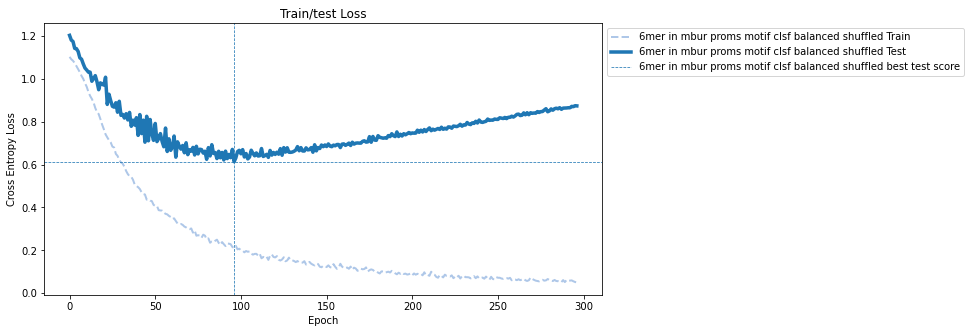

In [21]:
cnn3_name = "6mer in mbur proms motif clsf balanced shuffled"
model3 = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=6,
    fc_node_num=10
)

model_res[cnn3_name] = tu.collect_model_stats(
    cnn3_name,
    seq_len,
    ohe_train_dl_shuff,
    ohe_val_dl_shuff,
    DEVICE,
    lr=0.0001,
    ep=3000,
    pat=200,
    opt=torch.optim.Adam,
    model=model3,
    loss_type='classification'
)

Running predictions for 6mer in mbur proms motif clsf balanced shuffled


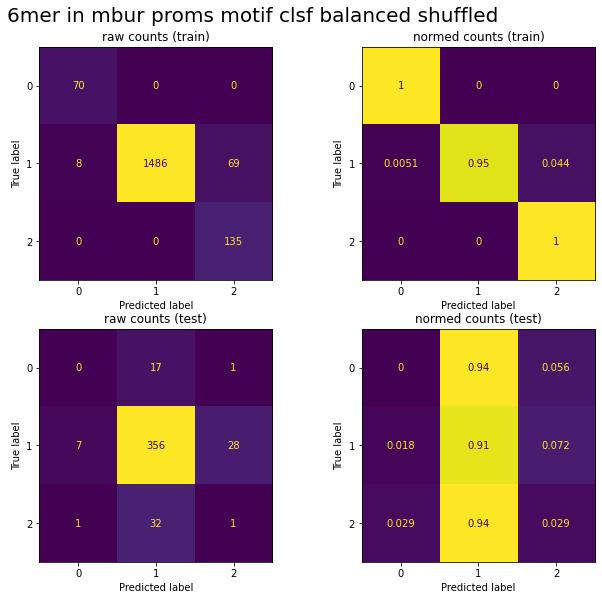

In [22]:
seq_list_shuff = [
    (train_df[seq_col].values,train_df[target_col],"train"),
    (test_df[seq_col].values,test_df[target_col],"test")
]

pred_dfs[cnn3_name] = tu.get_confusion_stats(
    model_res[cnn3_name]['model'],
    model_res[cnn3_name]['model_name'],
    seq_list_shuff,
    DEVICE,
    title=f"{model_res[cnn3_name]['model_name']}"
)

Total convolutional layers: 1
Num filters 8
filt_width 6
Seq 0 of 1768
Seq 100 of 1768
Seq 200 of 1768
Seq 300 of 1768
Seq 400 of 1768
Seq 500 of 1768
Seq 600 of 1768
Seq 700 of 1768
Seq 800 of 1768
Seq 900 of 1768
Seq 1000 of 1768
Seq 1100 of 1768
Seq 1200 of 1768
Seq 1300 of 1768
Seq 1400 of 1768
Seq 1500 of 1768
Seq 1600 of 1768
Seq 1700 of 1768
torch.Size([8, 4, 6])


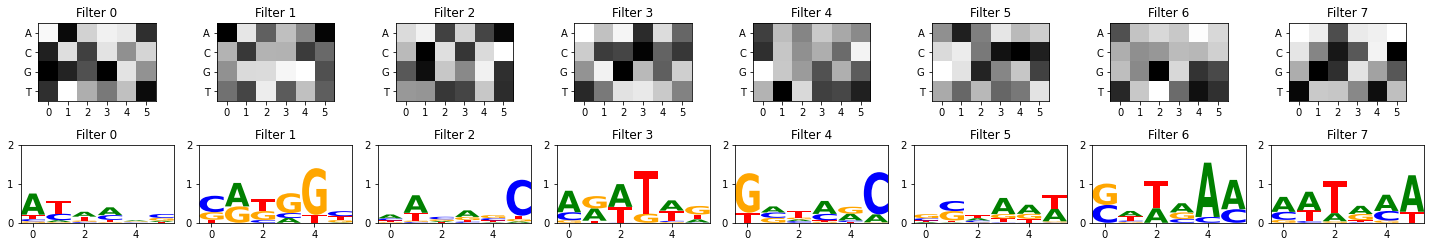

In [23]:
# Check filters of Model 2?
seqs = train_df['upstream_region'].values
v.view_conv2D_wrapper(model2,seqs,DEVICE,act_thresh=1.0,ysc=0.25)

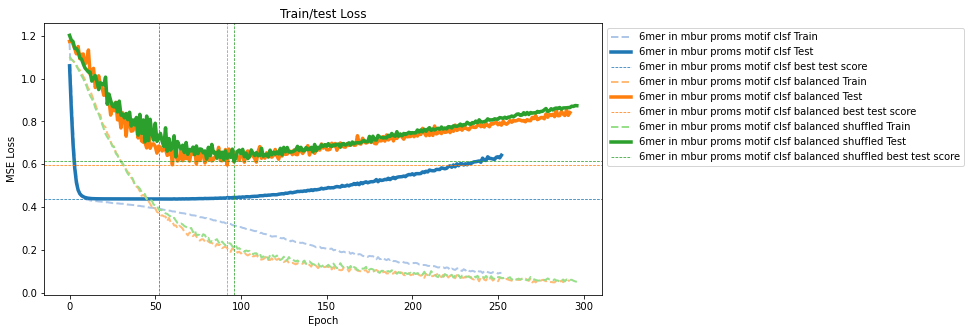

In [24]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

In [25]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

,model_name,split,mac_precision,mac_recall,mac_f1,support
0,6mer in mbur proms motif clsf,train,0.294683,0.333333,0.312819,1768
1,6mer in mbur proms motif clsf,test,0.294206,0.333333,0.312550,443
0,6mer in mbur proms motif clsf balanced,train,0.850553,0.986351,0.908530,1768
1,6mer in mbur proms motif clsf balanced,test,0.359585,0.350763,0.354426,443
0,6mer in mbur proms motif clsf balanced shuffled,train,0.853067,0.983579,0.905717,1768
1,6mer in mbur proms motif clsf balanced shuffled,test,0.304115,0.313299,0.308574,443


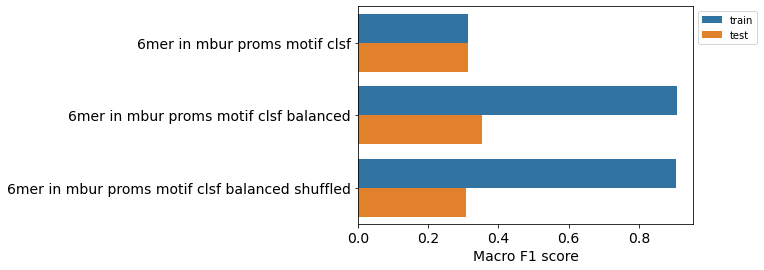

In [26]:
sns.barplot(data=all_preds,y='model_name',x='mac_f1',hue='split',dodge=True)
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel("Macro F1 score",fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
plt.show()

In this synthetic example, the models are overfitting to the training data and seemingly unable to generalize to the test data. Maybe in this case, the signal-noise is too hard to overcome with only these sequences?

To test this, instead of starting with actual M. buryatense sequences, let's randomly generate a bunch!

## Use more randomly generated sequences

In [27]:
seq_length = 300
syn_seqs = []

with tqdm.trange(10000) as pbar:
    for i in pbar:
        if i%1000 == 0:
            pbar.set_description(f"i:{i}")
        my_seq = ''.join(np.random.choice(('C','G','T','A'), seq_length ))
        syn_seqs.append((i,my_seq))

syn_df = pd.DataFrame(syn_seqs,columns=['id','seq'])
syn_df.head()


i:9000: 100%|██████████| 10000/10000 [00:00<00:00, 11698.56it/s]


,id,seq
0,0,CAACTGTCTATCATTAGAGCCAACGCACAACGTCTCTGGCATAAAG...
1,1,GATTCTCTGCCGCTTCTACGACGTGATCTCCGGGAAGATTAATCTT...
2,2,GTTCCTGCTTAGAGCGTTGGGAGCAAGCATAGCGTTTGAGCATGTT...
3,3,AGCACTCCGCAATAGTAGAACAAGGCACATTCCCGGGCATCGGCCG...
4,4,CTTCTAAGGCGACCGACAAAGTTCAGAAGTAATGCTCCTACCGACG...


In [28]:
syn_df['score'] = syn_df['seq'].apply(lambda x: score_seq(x))
syn_df

,id,seq,score
0,0,CAACTGTCTATCATTAGAGCCAACGCACAACGTCTCTGGCATAAAG...,0.310000
1,1,GATTCTCTGCCGCTTCTACGACGTGATCTCCGGGAAGATTAATCTT...,-0.080000
2,2,GTTCCTGCTTAGAGCGTTGGGAGCAAGCATAGCGTTTGAGCATGTT...,-0.040000
3,3,AGCACTCCGCAATAGTAGAACAAGGCACATTCCCGGGCATCGGCCG...,0.260000
4,4,CTTCTAAGGCGACCGACAAAGTTCAGAAGTAATGCTCCTACCGACG...,0.040000
...,...,...,...
9995,9995,TGCATCGAGATCGTAAAAAGGTAATCATCGCCGCCGGCCATAAATT...,0.166667
9996,9996,ACAGGGTCGTCGAACACCCCAGGATGATGCCGAATTCGGCAAGGGC...,10.246667
9997,9997,AGGGCTTCACGAATCTGCGAGTGAATCCCTTTATCCAGGGTGAGCG...,-0.013333
9998,9998,CGACATAGGCGGTTATGCATCTGGGAGCCGTGGCGCAACTCTGGTT...,-0.353333


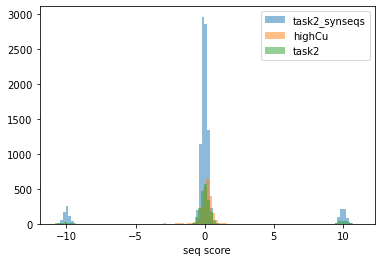

In [29]:
plt.hist(syn_df['score'],bins=100,alpha=0.5,label='task2_synseqs')
plt.hist(XYdf['highCu'],bins=50,alpha=0.5,label='highCu')
plt.hist(XYdf['score'],bins=100,alpha=0.5,label='task2')
plt.xlabel("seq score")
plt.legend()
plt.show()

In [30]:
tu.set_reg_class_up_down(syn_df,'score',thresh=5)
syn_df['score_reg_UD'].value_counts()

1    8741
2     631
0     628
Name: score_reg_UD, dtype: int64

In [31]:
# rename for convenience
syn_df = syn_df.rename(columns={'score_reg_UD':'task2_class'})
syn_df.columns

Index(['id', 'seq', 'score', 'task2_class'], dtype='object')

Train counts:
1    6993
2     505
0     502
Name: task2_class, dtype: int64
Test counts:
1    1748
0     126
2     126
Name: task2_class, dtype: int64


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


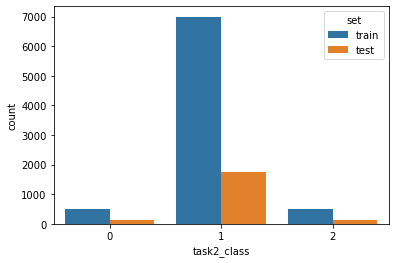

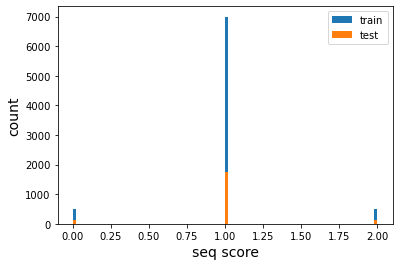

/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


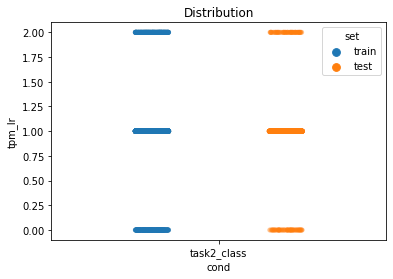

In [32]:
target_col = 'task2_class'
for i, (train_idxs, test_idxs) in enumerate(sss.split(syn_df, syn_df[target_col])):
    syn_train_df = syn_df.iloc[train_idxs]
    syn_test_df = syn_df.iloc[test_idxs]
    
    print(f"Train counts:\n{syn_train_df[target_col].value_counts()}")
    print(f"Test counts:\n{syn_test_df[target_col].value_counts()}")
    
    v.plot_train_test_stacks(syn_train_df, syn_test_df, score_col=target_col)
    v.plot_train_test_hist(syn_train_df, syn_test_df,score_col=target_col,bins=100)
    v.view_train_test_dist(syn_train_df, syn_test_df,[target_col],id_col='id')


## Load seqs into data loaders

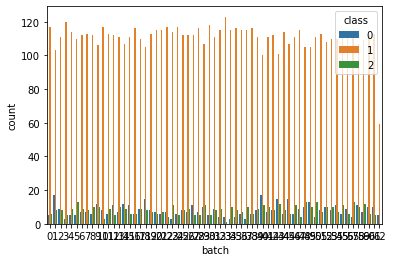

In [33]:
seq_col = 'seq'
target_col = 'task2_class'

dataset_types = [
    DatasetSpec('ohe'),
]

syn_dls = tu.build_dataloaders(
    syn_train_df, 
    syn_test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=None
)


syn_ohe_train_dl,syn_ohe_val_dl = syn_dls['ohe']

v.see_batch_class_dist(syn_ohe_train_dl)

E:54 | train loss:0.393 | val loss: 0.489:   2%|▏         | 55/3000 [00:21<19:24,  2.53it/s]

EarlyStopping counter: 50 out of 200


E:104 | train loss:0.346 | val loss: 0.533:   4%|▎         | 105/3000 [00:41<19:12,  2.51it/s]

EarlyStopping counter: 100 out of 200


E:154 | train loss:0.317 | val loss: 0.567:   5%|▌         | 155/3000 [01:01<18:47,  2.52it/s]

EarlyStopping counter: 150 out of 200


E:204 | train loss:0.289 | val loss: 0.599:   7%|▋         | 204/3000 [01:21<18:34,  2.51it/s]

EarlyStopping counter: 200 out of 200
Early stopping


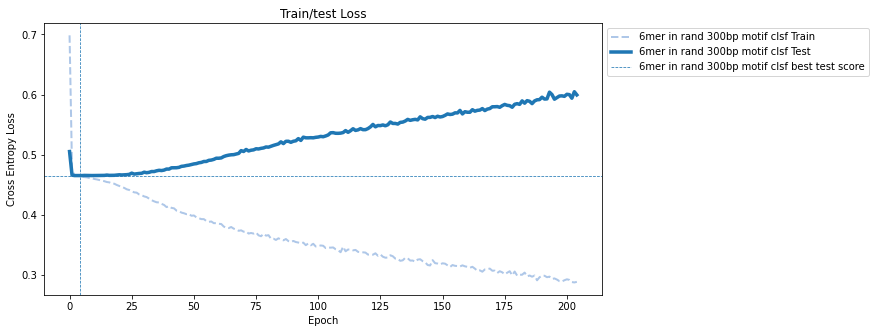

In [37]:
cnn5_name = "6mer in rand 300bp motif clsf"
model5 = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=6,
    fc_node_num=10
)

seq_len=len(syn_train_df[seq_col].values[0])

model_res[cnn5_name] = tu.collect_model_stats(
    cnn5_name,
    seq_len,
    syn_ohe_train_dl,
    syn_ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=3000,
    pat=200,
    opt=torch.optim.Adam,
    model=model5,
    loss_type='classification'
)

Running predictions for 6mer in rand 300bp motif clsf


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


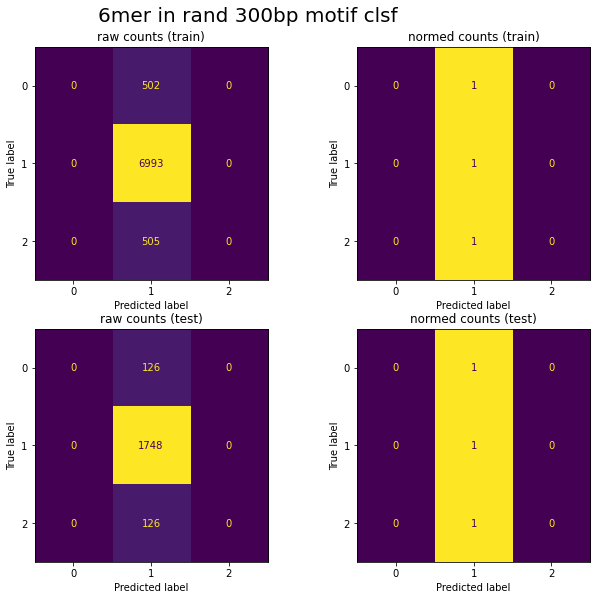

In [44]:
syn_seq_list = [
    (syn_train_df[seq_col].values,syn_train_df[target_col],"train"),
    (syn_test_df[seq_col].values,syn_test_df[target_col],"test")
]

pred_dfs[cnn5_name] = tu.get_confusion_stats(
    model_res[cnn5_name]['model'],
    model_res[cnn5_name]['model_name'],
    syn_seq_list,
    DEVICE,
    title=f"{model_res[cnn5_name]['model_name']}"
)

# Retry with a balanced sampler

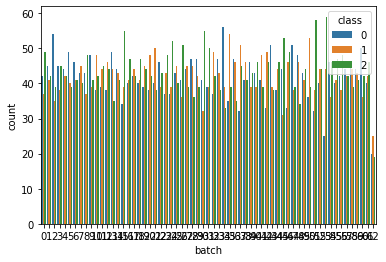

In [39]:
sampler = tu.make_weighted_sampler(syn_train_df,target_col)
syn_dls = tu.build_dataloaders(
    syn_train_df, 
    syn_test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=sampler,
    shuffle=False
)

syn_ohe_train_dl,syn_ohe_val_dl = syn_dls['ohe']

v.see_batch_class_dist(syn_ohe_train_dl)

E:164 | train loss:0.419 | val loss: 0.951:   3%|▎         | 165/5000 [01:04<31:35,  2.55it/s]

EarlyStopping counter: 125 out of 500


E:289 | train loss:0.246 | val loss: 0.974:   6%|▌         | 290/5000 [01:54<30:44,  2.55it/s]

EarlyStopping counter: 250 out of 500


E:414 | train loss:0.133 | val loss: 1.022:   8%|▊         | 415/5000 [02:43<29:51,  2.56it/s]

EarlyStopping counter: 375 out of 500


E:539 | train loss:0.087 | val loss: 1.124:  11%|█         | 539/5000 [03:32<29:16,  2.54it/s]

EarlyStopping counter: 500 out of 500
Early stopping


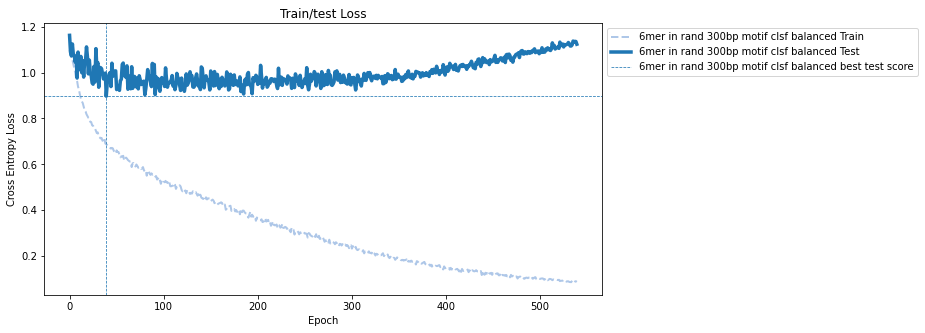

Running predictions for 6mer in rand 300bp motif clsf balanced


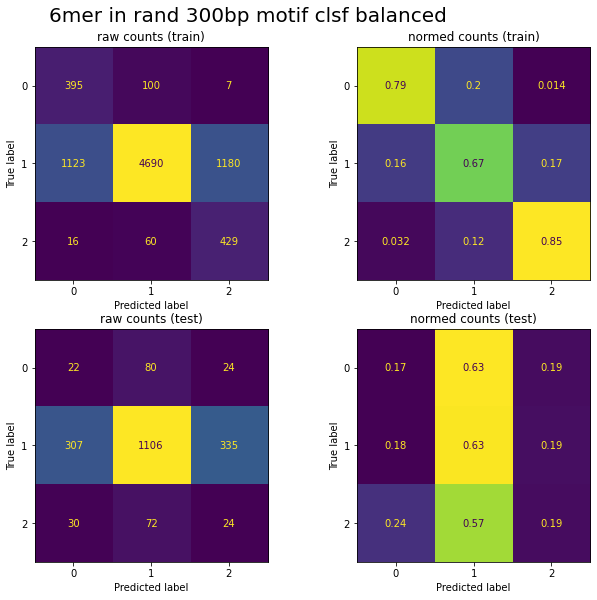

In [40]:
cnn6_name = "6mer in rand 300bp motif clsf balanced"
model6 = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=6,
    fc_node_num=10
)

model_res[cnn6_name] = tu.collect_model_stats(
    cnn6_name,
    seq_len,
    syn_ohe_train_dl,
    syn_ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model6,
    loss_type='classification'
)

pred_dfs[cnn6_name] = tu.get_confusion_stats(
    model_res[cnn6_name]['model'],
    model_res[cnn6_name]['model_name'],
    syn_seq_list,
    DEVICE,
    title=f"{model_res[cnn6_name]['model_name']}"
)

In [93]:
# class TINKER_DNA_CNN(nn.Module):
#     def __init__(self,
#                  seq_len,
#                  num_filters0=32,
#                  num_filters1=32,
#                  kernel_size0=8,
#                  kernel_size1=8,
#                  conv_pool_size0=1,
#                  conv_pool_size1=1,
#                  fc_node_num0 = 10,
#                  fc_node_num1 = 10
#                 ):
#         super().__init__()
        
#         self.seq_len = seq_len
        
#         # calculation for number of linear nodes need to come after final conv layer
#         linear_node_num = int(np.floor((seq_len - kernel_size0 + 1)/conv_pool_size0))
#         linear_node_num = int(np.floor((linear_node_num - kernel_size1 + 1)/conv_pool_size1))
#         linear_node_num = linear_node_num*num_filters1
#         #linear_node_num = linear_node_num*num_filters0
        
#         self.conv_net = nn.Sequential(
#             # Conv layer 0
#             nn.Conv2d(1, num_filters0, kernel_size=(4,kernel_size0)),
#             # ^^ changed from 4 to 1 channel??
#             nn.ReLU(),
#             nn.MaxPool2d((1,conv_pool_size0)), # def stride = kernel_size
#             nn.Dropout(0.5),

#             # Conv layer 1
#             nn.Conv2d(num_filters0, num_filters1, kernel_size=(1,kernel_size1)),
#             nn.ReLU(),
            
#             nn.Flatten(),
#             # Fully connected layer 0
#             nn.Linear(linear_node_num, fc_node_num0),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             # Fully connected layer 0
# #             nn.Linear(fc_node_num0, fc_node_num1),
# #             nn.ReLU(),
#             # final prediction
#             nn.Linear(fc_node_num0, 3),
#             #nn.Softmax(dim=1)
#         ) 

#     def forward(self, xb):
#         # reshape view to batch_ssize x 4channel x seq_len
#         # permute to put channel in correct order
        
#         #xb = xb.permute(0,2,1) 
#         # OHE FIX??
        
#         xb = xb.permute(0,2,1).unsqueeze(1)
#         # ^^ Conv2D input fix??
        
#         out = self.conv_net(xb)
#         return out

# model7 = TINKER_DNA_CNN(
#     seq_len,
#     num_filters0=32,
#     num_filters1=32,
#     kernel_size0=6,
#     kernel_size1=6,
#     conv_pool_size0=3,
# #     conv_pool_size1=1,
#     fc_node_num0=10,
#     fc_node_num1=10
# )

Hm, still not getting there. Maybe we need a more complex model?

E:1337 | train loss:0.143 | val loss: 0.185:  27%|██▋       | 1338/5000 [10:52<29:47,  2.05it/s]

EarlyStopping counter: 125 out of 500


E:1462 | train loss:0.135 | val loss: 0.178:  29%|██▉       | 1463/5000 [11:53<28:46,  2.05it/s]

EarlyStopping counter: 250 out of 500


E:1587 | train loss:0.116 | val loss: 0.179:  32%|███▏      | 1588/5000 [12:54<27:46,  2.05it/s]

EarlyStopping counter: 375 out of 500


E:1712 | train loss:0.121 | val loss: 0.183:  34%|███▍      | 1712/5000 [13:55<26:45,  2.05it/s]

EarlyStopping counter: 500 out of 500
Early stopping


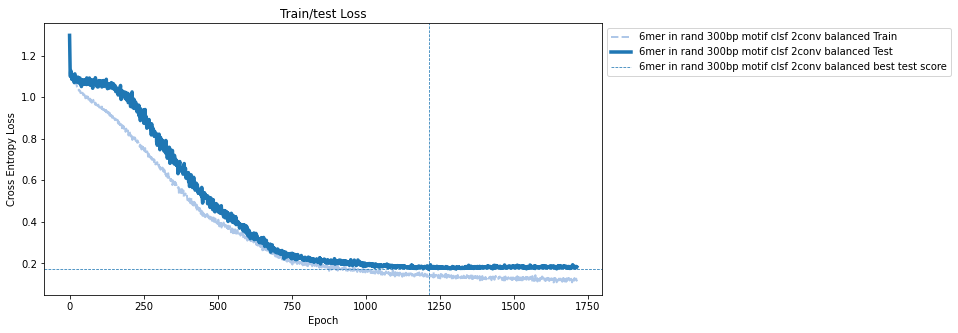

Running predictions for 6mer in rand 300bp motif clsf 2conv balanced


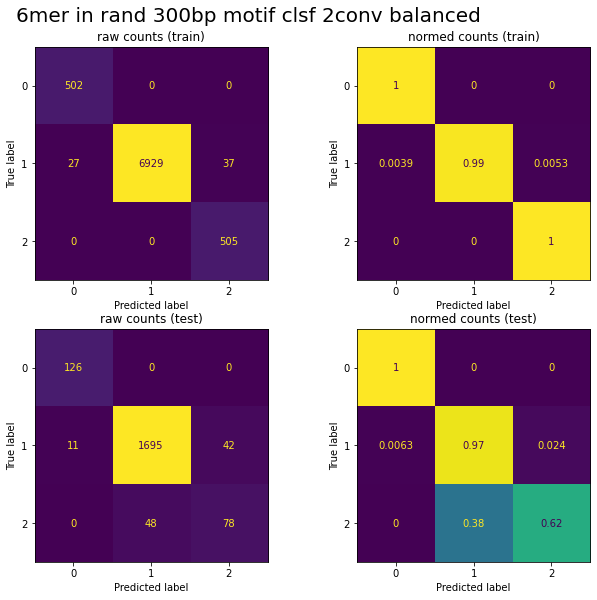

In [42]:
cnn7_name = "6mer in rand 300bp motif clsf 2conv balanced"

model7 = m.DNA_2CNN_2FC(
    seq_len,
    num_classes=3,
    num_filters1=8,
    num_filters2=8,
    kernel_size1=6,
    kernel_size2=6,
    conv_pool_size1=3,
    fc_node_num1=10,
    fc_node_num2=10,
)

model_res[cnn7_name] = tu.collect_model_stats(
    cnn7_name,
    seq_len,
    syn_ohe_train_dl,
    syn_ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model7,
    loss_type='classification'
)

pred_dfs[cnn7_name] = tu.get_confusion_stats(
    model_res[cnn7_name]['model'],
    model_res[cnn7_name]['model_name'],
    syn_seq_list,
    DEVICE,
    title=f"{model_res[cnn7_name]['model_name']}"
)

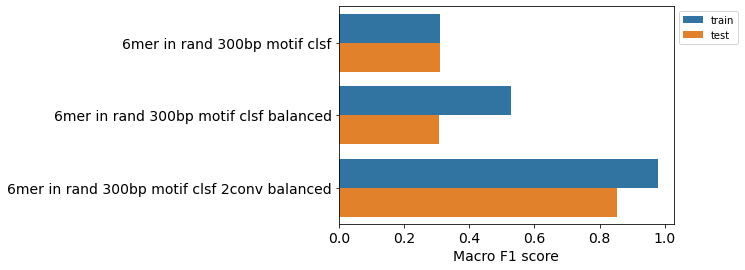

In [56]:
syn_preds = pd.concat([pred_dfs[x] for x in pred_dfs if 'rand' in x])
syn_preds

sns.barplot(data=syn_preds,y='model_name',x='mac_f1',hue='split',dodge=True)
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel("Macro F1 score",fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
plt.show()

Ok so this pretty much worked! It's not perfect but the Mac F1 is actually quite good!

Was it just that we needed a more complex model for a more complex task?

Let's retry with the original M bur sequences and the 2 layer model

E:538 | train loss:0.330 | val loss: 0.784:  11%|█         | 539/5000 [00:59<08:12,  9.06it/s]

EarlyStopping counter: 125 out of 500


E:784 | train loss:0.238 | val loss: 0.792:  16%|█▌        | 785/5000 [01:26<07:50,  8.96it/s]

EarlyStopping counter: 125 out of 500


E:909 | train loss:0.214 | val loss: 0.800:  18%|█▊        | 910/5000 [01:40<07:30,  9.07it/s]

EarlyStopping counter: 250 out of 500


E:1034 | train loss:0.229 | val loss: 0.801:  21%|██        | 1035/5000 [01:54<07:14,  9.13it/s]

EarlyStopping counter: 375 out of 500


E:1158 | train loss:0.209 | val loss: 0.819:  23%|██▎       | 1158/5000 [02:08<07:04,  9.04it/s]


EarlyStopping counter: 500 out of 500
Early stopping


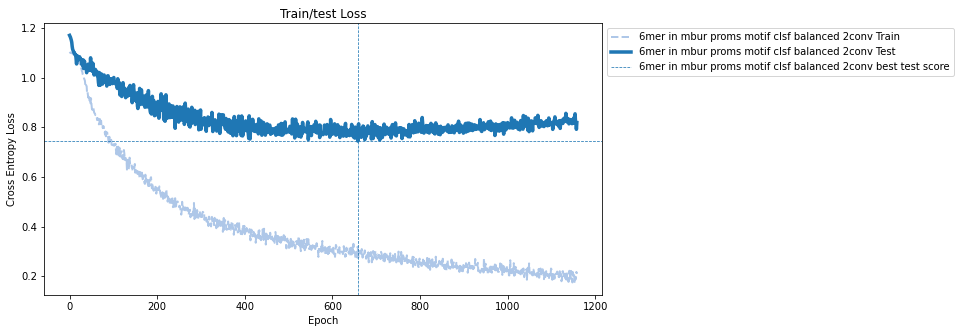

Running predictions for 6mer in mbur proms motif clsf balanced 2conv


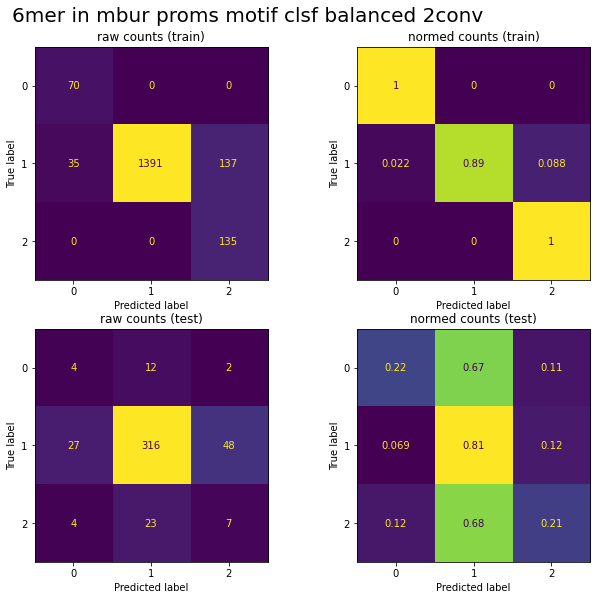

In [57]:
model8 = m.DNA_2CNN_2FC(
    seq_len,
    num_classes=3,
    num_filters1=8,
    num_filters2=8,
    kernel_size1=6,
    kernel_size2=6,
    conv_pool_size1=3,
    fc_node_num1=10,
    fc_node_num2=10,
)

cnn8_name = "6mer in mbur proms motif clsf balanced 2conv"

model_res[cnn8_name] = tu.collect_model_stats(
    cnn8_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model8,
    loss_type='classification'
)

pred_dfs[cnn8_name] = tu.get_confusion_stats(
    model_res[cnn8_name]['model'],
    model_res[cnn8_name]['model_name'],
    seq_list,
    DEVICE,
    title=f"{model_res[cnn8_name]['model_name']}"
)

In [ ]:
# does the 2conv model work on the 5G seqs?
# if so, how does the f1 compare?

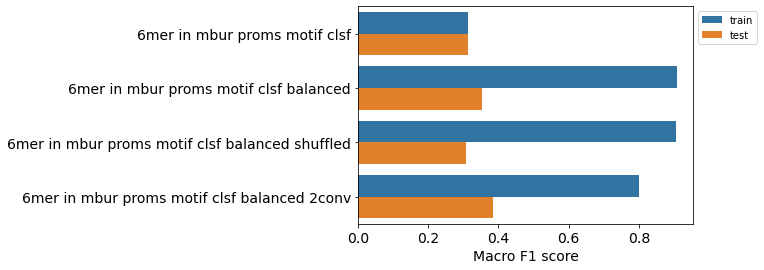

In [60]:
mbur_preds = pd.concat([pred_dfs[x] for x in pred_dfs if 'mbur' in x])
mbur_preds

sns.barplot(data=mbur_preds,y='model_name',x='mac_f1',hue='split',dodge=True)
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel("Macro F1 score",fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
plt.show()


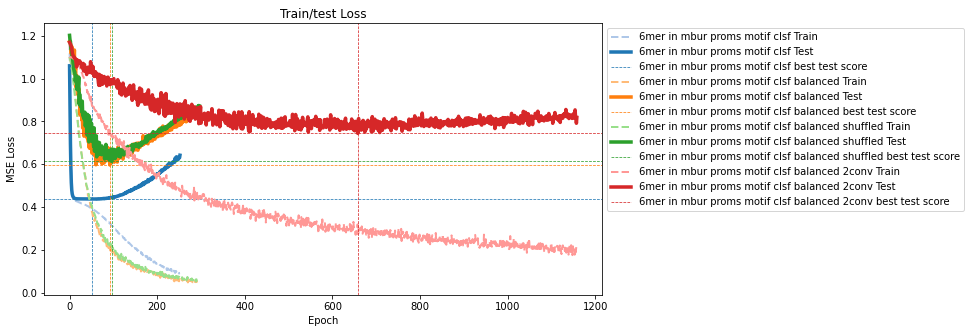

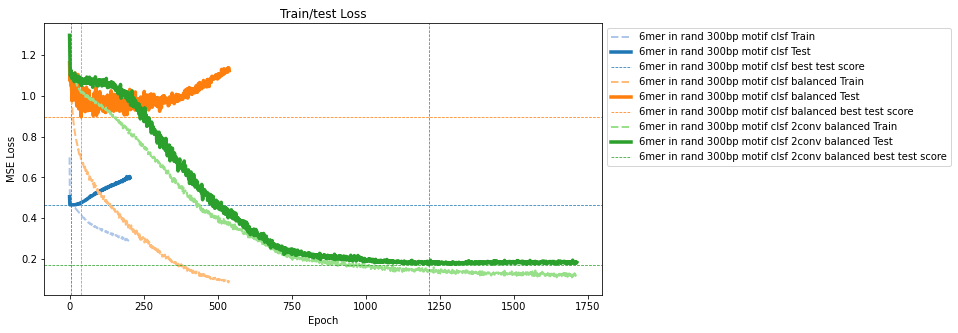

In [61]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res if 'mbur' in x])
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res if 'rand' in x])

The 2conv layers seemed to help a little on the M. buryatense sequences, but didn't do quite as well as the 10 random sequences.

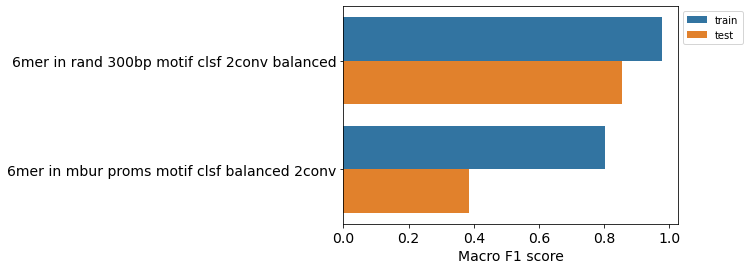

In [62]:
conv2_preds = pd.concat([pred_dfs[x] for x in pred_dfs if '2conv' in x])
conv2_preds

sns.barplot(data=conv2_preds,y='model_name',x='mac_f1',hue='split',dodge=True)
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel("Macro F1 score",fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
plt.show()


It seems like there's a few different dimensions to play with here:
* How many total sequences are there? (affects total training examples)
* How long are the sequences? (affects the signal to noise ratio of the 6-mer)
* How complex is the model?

After running a number of combinations of each of these levers in `synth_classification_randomseqs.py`, here are some summary plots

# Summary of model performance.
Varied:
* Model arch: Simple CNN, 2Conv CNN, 2Conv CNN with Pooling
* Number of training seqs: 2K, 6K, 10K
* Length of sequence: 50bp, 150bp, 300bp
* Ran 5 folds for each level

In [63]:
from os import listdir

In [64]:
dirname = '../hyak_scp_dump/out_synth_cls/'
filenames = listdir(dirname)
tsvs = [filename for filename in filenames if filename.endswith('.tsv')]
tsvs

['2CNN_fold3_50bp_2000seqs_pred_res.tsv',
 'CNN_simple_fold1_300bp_2000seqs_pred_res.tsv',
 'CNN_simple_fold0_150bp_2000seqs_pred_res.tsv',
 '2CNN_fold4_50bp_2000seqs_pred_res.tsv',
 '2CNN_pool_fold4_300bp_2000seqs_pred_res.tsv',
 'CNN_simple_fold2_150bp_2000seqs_pred_res.tsv',
 'CNN_simple_fold4_300bp_2000seqs_pred_res.tsv',
 '2CNN_pool_fold3_300bp_2000seqs_pred_res.tsv',
 '2CNN_pool_fold2_150bp_2000seqs_pred_res.tsv',
 '2CNN_fold1_50bp_2000seqs_pred_res.tsv',
 'CNN_simple_fold4_150bp_2000seqs_pred_res.tsv',
 '2CNN_pool_fold3_150bp_2000seqs_pred_res.tsv',
 'CNN_simple_fold1_50bp_2000seqs_pred_res.tsv',
 '2CNN_fold1_150bp_2000seqs_pred_res.tsv',
 '2CNN_pool_fold4_150bp_2000seqs_pred_res.tsv',
 'CNN_simple_fold4_50bp_2000seqs_pred_res.tsv',
 '2CNN_fold4_150bp_2000seqs_pred_res.tsv',
 '2CNN_pool_fold4_50bp_2000seqs_pred_res.tsv',
 '2CNN_pool_fold0_150bp_2000seqs_pred_res.tsv',
 'CNN_simple_fold0_50bp_2000seqs_pred_res.tsv',
 'CNN_simple_fold2_300bp_2000seqs_pred_res.tsv',
 '2CNN_pool_fol

In [65]:
df = pd.DataFrame()
for f in tsvs:
    df_new = pd.read_csv(f'{dirname}/{f}',sep='\t')
    df = pd.concat([df,df_new])
    
df

,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,ds_size,fold,best_val_score,epoch_stop,total_time
0,2CNN_fold3_50bp_2000seqs,train,0.793548,0.996381,0.872708,1600,2CNN,2000,3,0.280525,781,56.755732
1,2CNN_fold3_50bp_2000seqs,test,0.356619,0.383802,0.363327,400,2CNN,2000,3,0.280525,781,56.755732
0,CNN_simple_fold1_300bp_2000seqs,train,0.877698,0.989293,0.927214,1600,CNN_simple,2000,1,0.635811,96,23.515346
1,CNN_simple_fold1_300bp_2000seqs,test,0.326046,0.326104,0.325260,400,CNN_simple,2000,1,0.635811,96,23.515346
0,CNN_simple_fold0_150bp_2000seqs,train,0.785173,0.988614,0.866150,1600,CNN_simple,2000,0,0.460809,180,23.646777
...,...,...,...,...,...,...,...,...,...,...,...,...
1,2CNN_fold0_50bp_2000seqs,test,0.356656,0.385507,0.364219,400,2CNN,2000,0,0.289136,871,60.817387
0,2CNN_pool_fold1_50bp_2000seqs,train,0.767241,0.995956,0.854050,1600,2CNN_pool,2000,1,0.179892,1662,105.846317
1,2CNN_pool_fold1_50bp_2000seqs,test,0.437676,0.395737,0.411146,400,2CNN_pool,2000,1,0.179892,1662,105.846317
0,CNN_simple_fold2_50bp_2000seqs,train,0.718008,0.994679,0.817854,1600,CNN_simple,2000,2,0.255622,349,27.322768


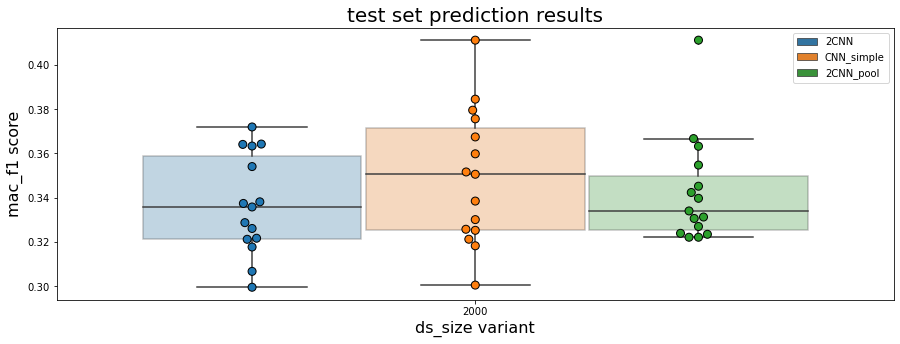

In [69]:
box_swarm_plot(df, 'mac_f1','test','ds_size','model_type')


In [70]:
def parse_seq_len(name):
    if '_300bp_' in name:
        return 300
    elif '_150bp' in name:
        return 150
    elif '_50bp_' in name:
        return 50
    else:
        raise ValueError("Unknown bp")


In [71]:
df['seq_len'] = df['model_name'].apply(lambda x: parse_seq_len(x))

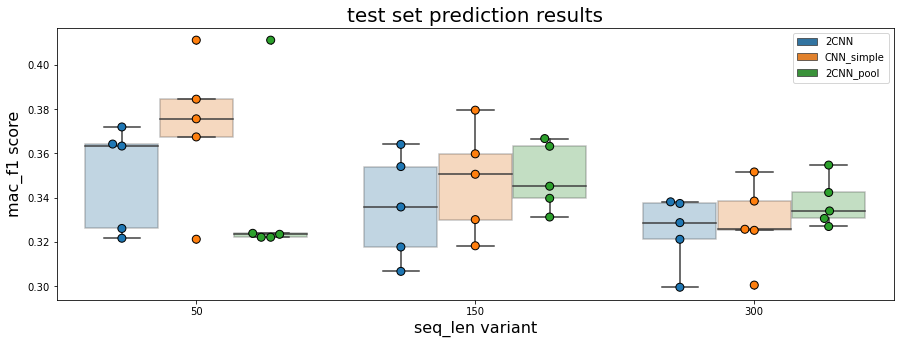

In [72]:
box_swarm_plot(df, 'mac_f1','test','seq_len','model_type')


In [67]:
def box_swarm_plot(df,metric,split,x_col,hue_col,yrange=None):
    df_split = df[df['split']==split]
    
    fig = plt.figure(figsize=(15,5))
    ax = sns.boxplot(data=df_split,x=x_col,y=metric,hue=hue_col,dodge=True,boxprops=dict(alpha=.3))
    plt.setp(ax.collections,alpha=0.3)

    handles = ax.legend_.legendHandles
    labels = [text.get_text() for text in ax.legend_.texts]

    sns.swarmplot(data=df_split,x=x_col,y=metric,hue=hue_col,
                  dodge=True,edgecolor='black',linewidth=1,ax=ax,size=8)

    plt.legend(handles, labels,loc='best')
    plt.ylim(yrange)
    plt.ylabel(f"{metric} score",fontsize=16)
    plt.xlabel(f"{x_col} variant",fontsize=16)
    plt.title(f"{split} set prediction results",fontsize=20)
    plt.show()

In [75]:
df_test = df[df['split']=='test']
df_test.head()

,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,ds_size,fold,best_val_score,epoch_stop,total_time,seq_len
1,2CNN_fold3_50bp_2000seqs,test,0.356619,0.383802,0.363327,400,2CNN,2000,3,0.280525,781,56.755732,50
1,CNN_simple_fold1_300bp_2000seqs,test,0.326046,0.326104,0.325260,400,CNN_simple,2000,1,0.635811,96,23.515346,300
1,CNN_simple_fold0_150bp_2000seqs,test,0.378638,0.381571,0.379516,400,CNN_simple,2000,0,0.460809,180,23.646777,150
1,2CNN_fold4_50bp_2000seqs,test,0.325680,0.326513,0.326096,400,2CNN,2000,4,0.295719,499,44.518276,50
1,2CNN_pool_fold4_300bp_2000seqs,test,0.355296,0.381948,0.354730,400,2CNN_pool,2000,4,0.819073,225,37.030263,300


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


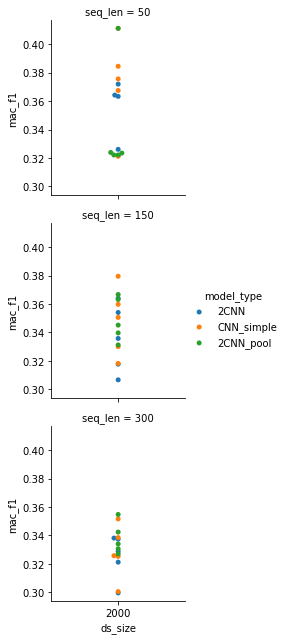

In [86]:
g = sns.FacetGrid(df_test, row="seq_len",hue='model_type')
g.map(sns.swarmplot,'ds_size','mac_f1',dodge=True)
g.add_legend()

(0.0, 1.0)

<Figure size 360x1440 with 0 Axes>

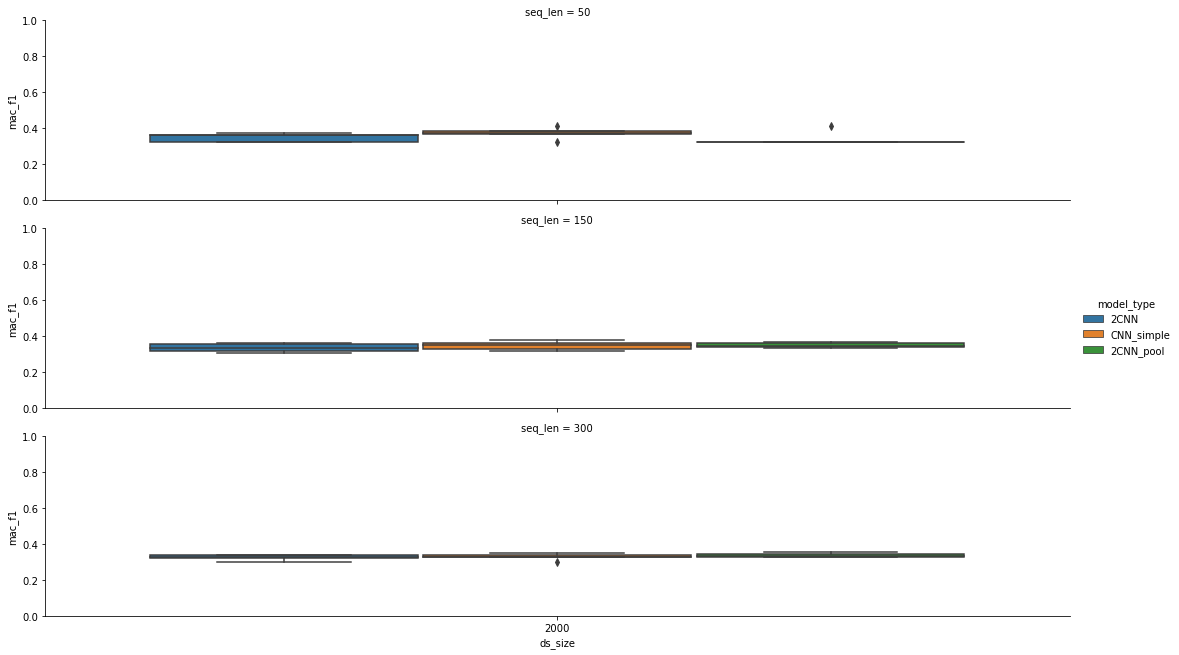

In [110]:
fig = plt.figure(figsize=(5,20))
sns.catplot(
    data=df_test, x='ds_size', y='mac_f1',
    row='seq_len', kind='box',hue='model_type',
    height=3,aspect=10/2
)
plt.ylim(0,1)

<Figure size 360x1440 with 0 Axes>

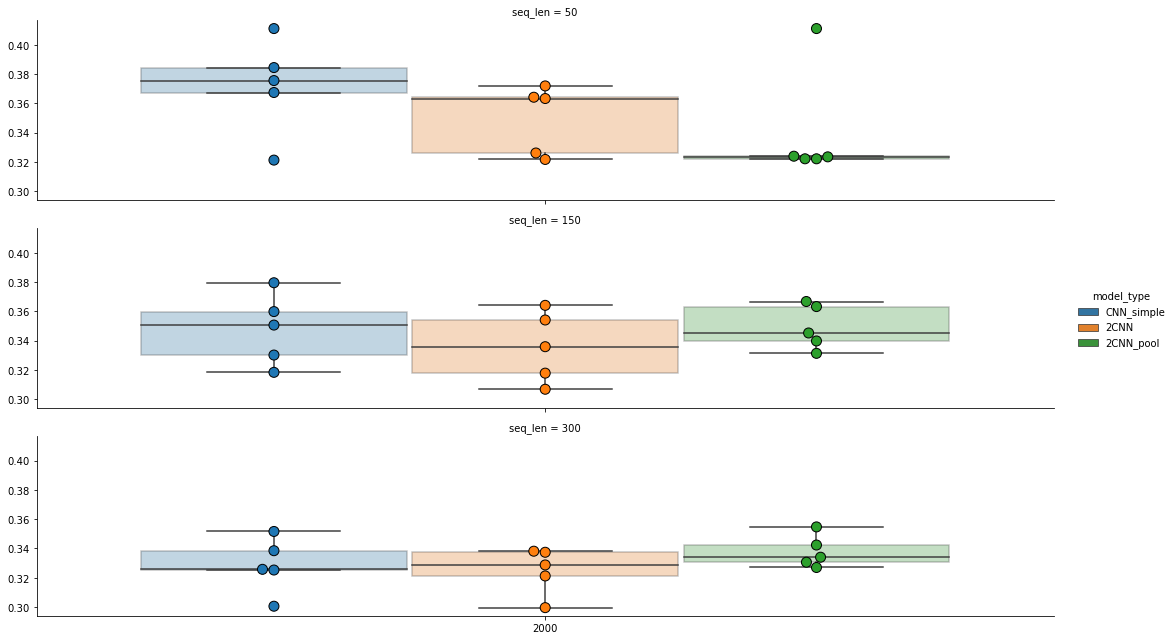

In [124]:
order = ['CNN_simple','2CNN','2CNN_pool']

fig = plt.figure(figsize=(5,20))

g = sns.catplot(
    data=df_test, x='ds_size', y='mac_f1',
    row='seq_len', kind='box',hue='model_type',
    hue_order=order,
    boxprops=dict(alpha=.3),height=3,aspect=10/2
)
g.map_dataframe(sns.swarmplot, x='ds_size', y='mac_f1',
                hue='model_type',size=10, 
                hue_order=order,
                edgecolor='black',linewidth=1, dodge=True,palette='tab10')
#plt.ylim(0,1)
plt.show()



<Figure size 360x1440 with 0 Axes>

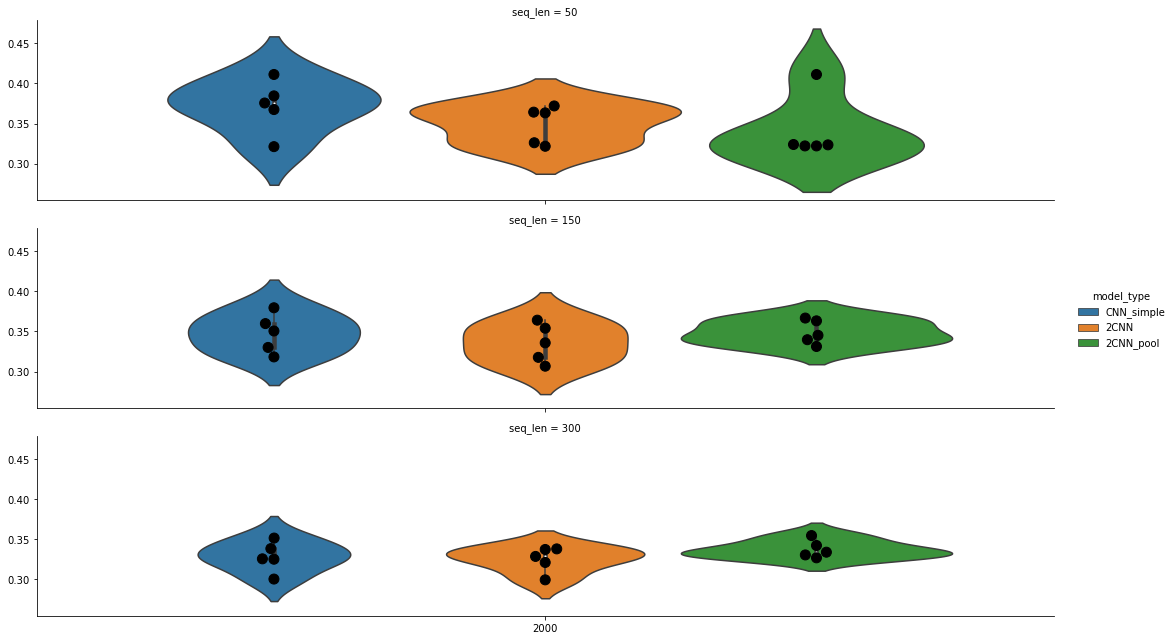

In [139]:
order = ['CNN_simple','2CNN','2CNN_pool']

fig = plt.figure(figsize=(5,20))

g = sns.catplot(
    data=df_test, x='ds_size', y='mac_f1',
    row='seq_len', kind='violin',hue='model_type',
    hue_order=order,
    alpha=.3,height=3,aspect=10/2
)

g.map_dataframe(sns.swarmplot, x='ds_size', y='mac_f1',
                hue='model_type',size=10, 
                hue_order=order,
                edgecolor='black',linewidth=1, dodge=True,palette=['black'])
#plt.ylim(0,1)
plt.show()



In [ ]:
g.set